In [200]:
nx.__version__

'2.5.1'

In [201]:
matplotlib.__version__

'3.4.1'

In [204]:
pd.__version__

'1.2.4'

In [205]:
import sklearn
sklearn.__version__

'0.24.1'

# Code for Network Analysis on Mapping Globalization through Event Themes

Elisa Nebres Jr. and Jefferson Tan

## Data Preparation

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

In [49]:
df_countries = pd.read_csv('Data/Raw/Country Mapping FIPS.csv')
df_countries.columns = ['Code', 'Country']

In [50]:
df_gdelt = pd.read_csv('Data/Raw/Gdelt Results.csv')

In [51]:
display(df_gdelt.head())

display(df_gdelt.info())

,event_year,flattened_locations,category,count
0,2016,AE,Law,132742
1,2016,PL,Law,292332
2,2016,GY,Law,13930
3,2017,GZ,Law,51551
4,2016,QA,Law,79671


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22071 entries, 0 to 22070
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   event_year           22071 non-null  int64 
 1   flattened_locations  22064 non-null  object
 2   category             22071 non-null  object
 3   count                22071 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 689.8+ KB


None

In [52]:
df_gdelt = pd.merge(df_gdelt, df_countries, how='left', left_on='flattened_locations', right_on = 'Code').dropna(axis=0, subset=['Code'])

df_gdelt.head()

,event_year,flattened_locations,category,count,Code,Country
0,2016,AE,Law,132742,AE,United Arab Emirates
1,2016,PL,Law,292332,PL,Poland
2,2016,GY,Law,13930,GY,Guyana
3,2017,GZ,Law,51551,GZ,Gaza Strip
4,2016,QA,Law,79671,QA,Qatar


In [53]:
df_gdelt.dropna(axis=0, subset=['Country'], inplace=True)

In [54]:
df_gdelt.to_csv('Data/Processed/dataframe_study.csv')

category
Government and Politics              562900655
Military                             482308605
Education                            410193535
Health                               282041526
Economic Policy                      281466554
Violence                             240608835
Religion                             229162578
Corruption                           186026794
Law                                  179785731
Agriculture                          164922144
Social Development and Protection    154234299
Urban and Rural Development           97610032
Social Issues                         75161506
Crime                                 59940843
Crisis                                54727386
Infrastructure                        40563408
Technology                              700479
Name: count, dtype: int64

Text(0.5, 1.0, 'Least 5 categories')

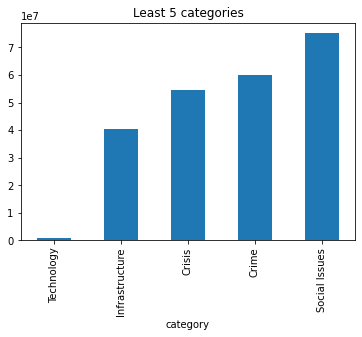

In [55]:
display(df_gdelt.groupby('category').sum()['count'].sort_values(ascending=False))
df_gdelt.groupby('category').sum()['count'].sort_values(ascending=True).head(5).plot(kind='bar')
plt.title('Least 5 categories')

In [56]:
#drop significant minorities
df_gdelt.drop(df_gdelt[df_gdelt.category == 'Technology'].index, inplace=True)

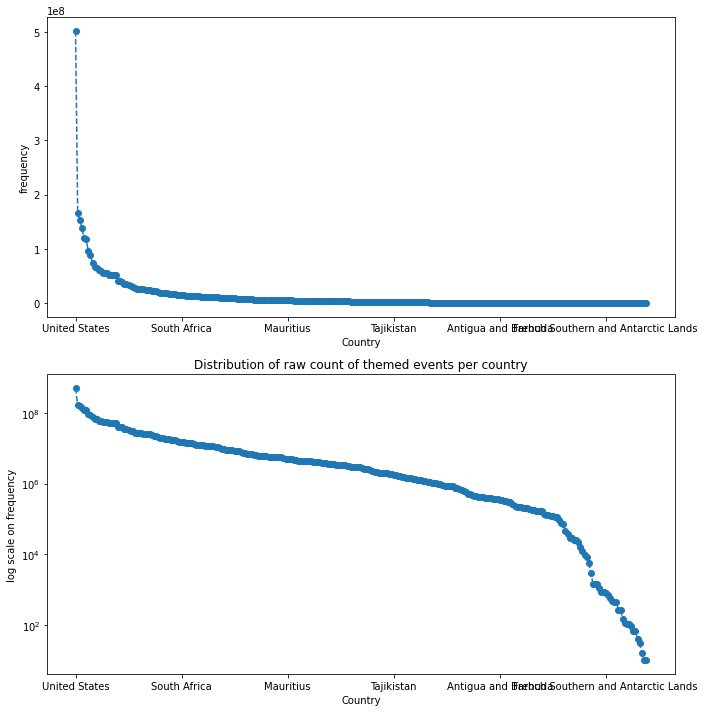

In [57]:
fig, ax =plt.subplots(2, 1, figsize=(10,10))
df_gdelt.groupby('Country').sum()['count'].sort_values(ascending=False).plot(style='o--', ax=ax[0])
ax[0].set_ylabel('frequency')
df_gdelt.groupby('Country').sum()['count'].sort_values(ascending=False).plot(style='o--', ax=ax[1], logy=True)
ax[1].set_ylabel('log scale on frequency')
plt.title('Distribution of raw count of themed events per country')

fig.tight_layout()
fig.savefig('Figures/1a-Distribution of Country Values.png', dpi=300);

In [58]:
df_country_filter = pd.DataFrame(df_gdelt.groupby('Country').sum()['count'].sort_values(ascending=False))

df_country_filter['cumsum'] = df_country_filter.cumsum()
df_country_filter['rate'] = range(1, len(df_country_filter.index) +1)

# sample:
display(df_country_filter.loc['Philippines'])

count       16590665
cumsum    2801696228
rate              48
Name: Philippines, dtype: int64

In [59]:
# filter out bottom set of countries
df_country_filtered = df_country_filter[df_country_filter['cumsum'] < 0.9*max(df_country_filter['cumsum'])]

# TRY: 
# df_country_filtered = df_country_filter[df_country_filter['rate'] 
#                                         < 0.8*max(df_country_filter['rate'])]

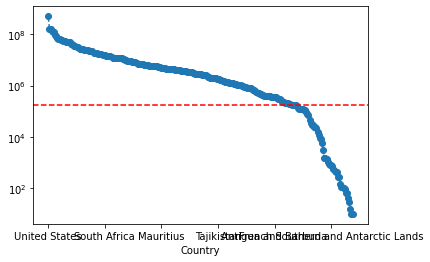

In [60]:
df_country_filter['count'].plot(style='o--', logy=True)
filter_count = df_country_filter[df_country_filter['rate'] 
                                 > 0.8*max(df_country_filter['rate'])].iloc[0]['count']

plt.axhline(y=filter_count, color='r', linestyle='--')

In [61]:
df_gdelt = df_gdelt[df_gdelt['Country'].isin(df_country_filtered.index)]

### Normalize the Values

We will normalize the values by year and country to address two biases:
1. Incomplete years.
1. Countries with more 'media outlets'.

In [62]:
df_normstats = df_gdelt.groupby(['event_year', 'Country']).agg(['min', 'max'])['count'].reset_index()

df_normstats.head()

,event_year,Country,min,max
0,2015,Afghanistan,36682,1209708
1,2015,Algeria,16741,300673
2,2015,Argentina,40082,865481
3,2015,Armenia,11668,328405
4,2015,Australia,128064,2012412


In [63]:
df_gdelt = df_gdelt.merge(df_normstats, on=['event_year', 'Country'])

In [64]:
df_gdelt['count_norm'] = (df_gdelt['count'] / (df_gdelt['max'] - df_gdelt['min'])) - (df_gdelt['min'] / (df_gdelt['max'] - df_gdelt['min']))

In [65]:
df_gdelt.head()

,event_year,flattened_locations,category,count,Code,Country,min,max,count_norm
0,2016,AE,Law,132742,AE,United Arab Emirates,45059,428244,0.228827
1,2016,AE,Crime,68619,AE,United Arab Emirates,45059,428244,0.061485
2,2016,AE,Crisis,62590,AE,United Arab Emirates,45059,428244,0.045751
3,2016,AE,Health,229811,AE,United Arab Emirates,45059,428244,0.482148
4,2016,AE,Military,428244,AE,United Arab Emirates,45059,428244,1.000000


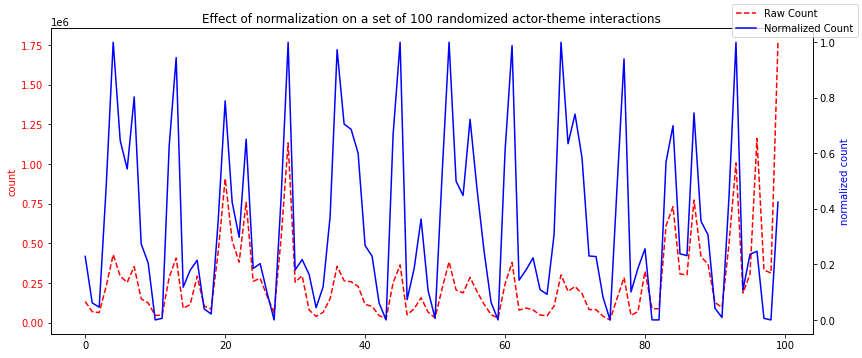

In [81]:
fig, ax = plt.subplots(figsize=(12,5))
plt.title('Effect of normalization on a set of 100 randomized actor-theme interactions')

df_gdelt['count'].head(100).plot(ax=ax, style='r--')
plt.ylabel('count', color='r')
[t.set_color('red') for t in ax.yaxis.get_ticklabels()]

df_gdelt['count_norm'].head(100).plot(ax=ax, style='b-', secondary_y=True)
plt.ylabel('normalized count', color='b')
 
plt.xlabel('index of randomized year-country to event interaction')

fig.legend(['Raw Count', 'Normalized Count'], loc='upper right')

fig.tight_layout()
fig.savefig('Figures/1b-Effect of Normalization.png', dpi=300);

#### Create a threshold for weak connections

**Comment:** This code looks wrong. 

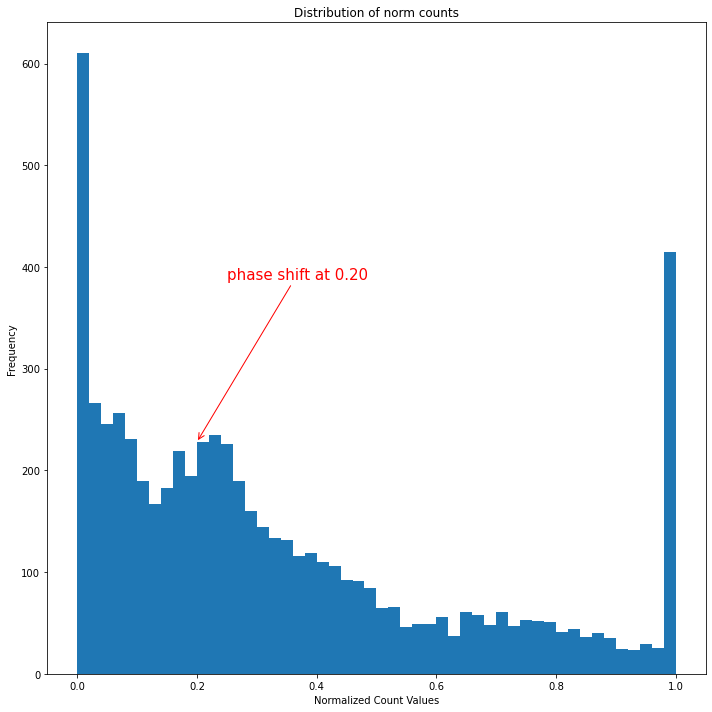

In [84]:
fig, ax = plt.subplots(figsize=(10,10))

df_gdelt['count_norm'].sort_values(ascending=False).plot(kind='hist', bins=50)
plt.title('Distribution of norm counts')

plt.annotate(xy = (.2, 228), text='phase shift at 0.20', color='red',
            xycoords='data', xytext=(.25, 400),
            arrowprops=dict(color='red', arrowstyle='->'),
            horizontalalignment='left', verticalalignment='top',
            size=15)

plt.xlabel('Normalized Count Values');

fig.tight_layout()
fig.savefig('Figures/1c-Distribution of Count Values.png', dpi=300);

In [85]:
df_gdelt.columns

Index(['event_year', 'flattened_locations', 'category', 'count', 'Code',
       'Country', 'min', 'max', 'count_norm'],
      dtype='object')

In [86]:
df_gdelt_all = df_gdelt.copy()

df_gdelt.drop(df_gdelt[df_gdelt['count_norm'] <=.2].index, inplace=True)
df_gdelt.reset_index(drop=True, inplace=True)

In [87]:
df_gdelt.to_csv('Data/Processed/dataframe_study_filtered_normalized.csv')

## Networkx

In [88]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from math import *
import numpy as np
%matplotlib inline

In [89]:
G = {} # nx Graph

countries = list(set(df_gdelt.Country.unique()))
events_G = df_gdelt.category.unique() 
years = list(set(df_gdelt.event_year.unique()))
years.sort()

In [90]:
for i in years:
    G[i] = nx.Graph()
    
    G[i].add_nodes_from(countries)
    G[i].add_nodes_from(events_G)
    
    G[i].add_weighted_edges_from(list(df_gdelt[df_gdelt['event_year'] == i][['Country', 'category', 'count_norm']].values))

In [91]:
G_proj = {} # projected

for i in G.keys():
    G_proj[i] = nx.bipartite.weighted_projected_graph(G[i], countries)

### Which Countries are Central in each event over the years?

Centrality was defined here as countries whose news are most prominent in that category.   
It is computed by getting the normalized count (0 to 1) of event categories of each country.

In [92]:
G_centrality = {}

for category in events_G:    
    temp_index = countries
    temp_index.sort()
    G_centrality[category] = pd.DataFrame(index = temp_index, columns = years)
    
    for i in years:
        temp_df = pd.DataFrame(list(G[i].edges.data('weight'))).set_index(0)
        G_centrality[category][i] = G_centrality[category].join(temp_df[temp_df[1] == category])[2]

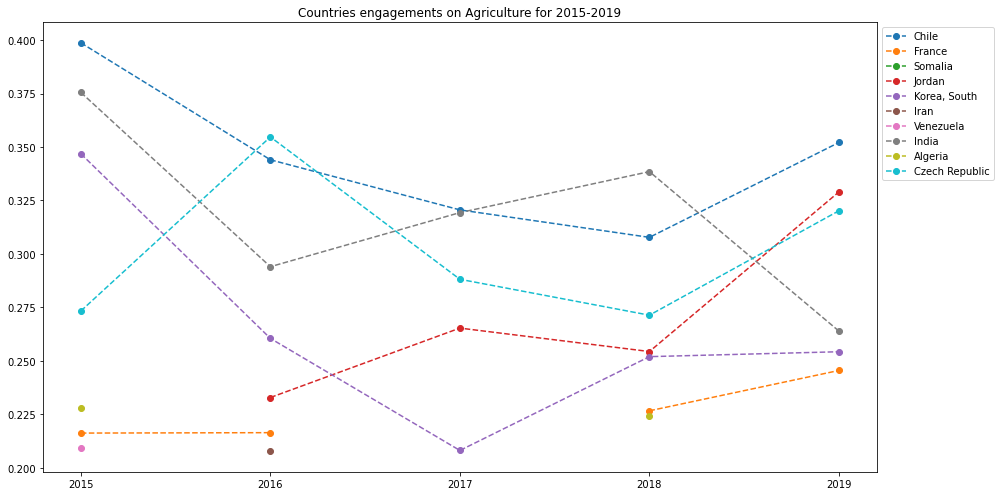

In [100]:
# Plot 10 random countries' normalized count (centrality) value for Agriculture YoY.
category = 'Agriculture'

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

G_centrality[category].loc[random.choices(G_centrality[category].index, k=10)]\
        .T.plot(ax=ax, label="Country", style='o--') # Why am I getting random.choices? Was this for illustration only?

ax.legend(bbox_to_anchor=(1, 1))
ax.set_xticks(years)
ax.set_title(f'Countries engagements on {category} for {min(years)}-{max(years)}')

fig.tight_layout()
fig.savefig('Figures/4b-Centrality.png', dpi=300);

In [108]:
print('Most central countries for Law, YoY')
[(col, G_centrality['Law'][col].idxmax(), G_centrality['Law'][col].max()) for col in G_centrality['Law'].columns]

Most central countries for Law, YoY


[(2015, 'United States', 0.4353511957181748),
 (2016, 'Argentina', 0.41720988617078353),
 (2017, 'Brazil', 0.477986379278338),
 (2018, 'United States', 0.46915548634411236),
 (2019, 'United States', 0.46817517741488474)]

<ipython-input-110-8fcc3146ff12>:34: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax[i].annotate(s = "%.2f" % v, xy = (j, list(set([x[0] for x in count_vals])).index(k)),


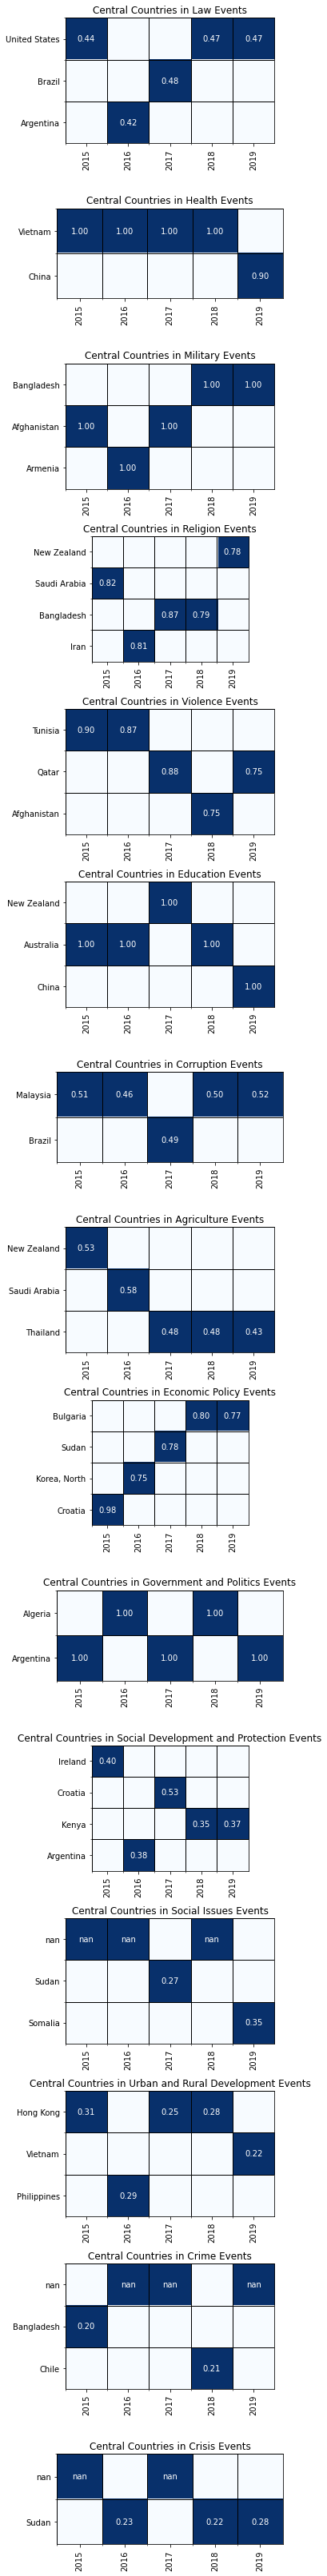

In [110]:
fig, ax = plt.subplots(len(G_centrality.items()), 1, 
                       figsize=(len(years), len(G_centrality.items())*3))

for i, (G_k, G_v) in enumerate(list(G_centrality.items())):
    count_vals = [(G_v[col].idxmax(), G_v[col].max()) for col in G_v.columns]
    this_array = np.zeros([len(list(set([x[0] for x in count_vals]))), len(years)])
    
    for j, each in enumerate(count_vals):
        this_array[list(set([x[0] for x in count_vals])).index(each[0]), j] = 1
    
    ax[i].imshow(this_array,
                cmap = 'Blues'
                )

    # Major ticks
    ax[i].set_xticks(range(len(years)));
    ax[i].set_yticks(range(len(set([x[0] for x in count_vals]))));

    # Labels for major ticks
    ax[i].set_xticklabels(years);
    ax[i].set_yticklabels(set([x[0] for x in count_vals]));

    # Minor ticks
    ax[i].set_xticks(np.arange(-.5, len(years)-1, 1), minor=True);
    ax[i].set_yticks(np.arange(-.5, len(set([x[0] for x in count_vals]))-1, 1), minor=True);

    # Gridlines based on minor ticks
    ax[i].grid(which='minor', color='k', linestyle='-', linewidth=1)

    ax[i].tick_params('x', rotation=90)
    ax[i].set_title(f'Central Countries in {G_k} Events')
    
    for j, (k, v) in enumerate(count_vals):
        ax[i].annotate(s = "%.2f" % v, xy = (j, list(set([x[0] for x in count_vals])).index(k)),
                      horizontalalignment='center', verticalalignment='center', size=10, color='white')

fig.tight_layout()
fig.savefig('Figures/4a-Centrality.png', dpi=300);

### Trends: Mapping out high change in countries' themes

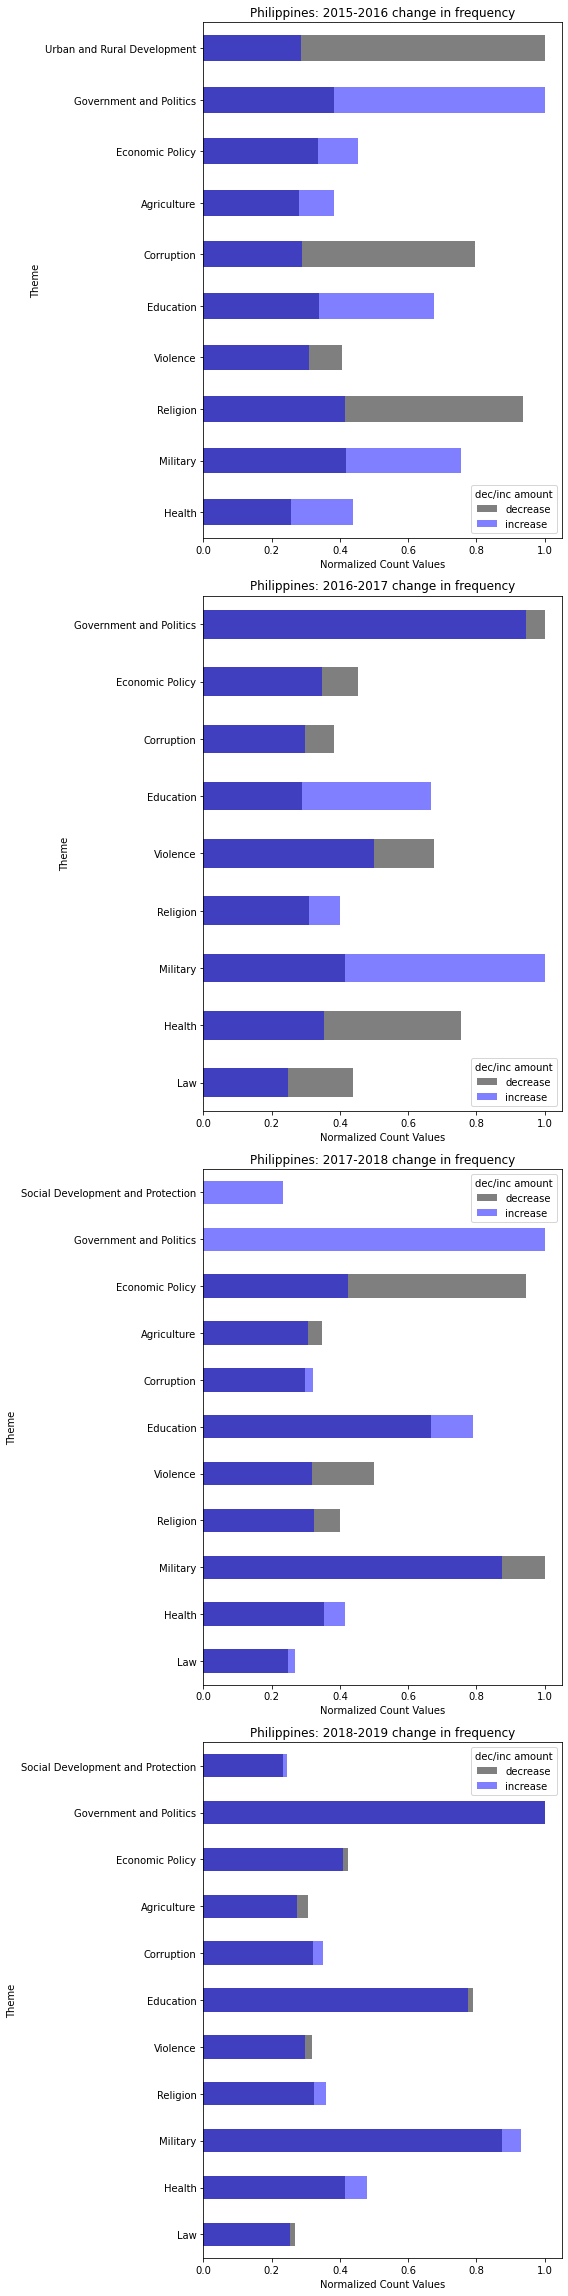

In [113]:
# Visualizing the change between 2 years for a country
fig, ax = plt.subplots(4, 1, figsize=(8,32));


for i, year in enumerate(range(2016, 2020)):

    (df_gdelt[(df_gdelt.Country == 'Philippines') & (df_gdelt.event_year == year-1)]
     [['category','count_norm']]).set_index('category').plot(kind='barh', ax=ax[i], label=year-1, width=.5, color='black', alpha=.5)
    (df_gdelt[(df_gdelt.Country == 'Philippines') & (df_gdelt.event_year == year)]
     [['category','count_norm']]).set_index('category').plot(kind='barh', ax=ax[i], label=year, width=.5, color='b', alpha=.5)

    ax[i].set_title(f'Philippines: {year-1}-{year} change in frequency')
    ax[i].legend(['decrease', 'increase'], title="dec/inc amount")
    ax[i].set_xlabel('Normalized Count Values')
    ax[i].set_ylabel('Theme')
    
fig.tight_layout()
fig.savefig('Figures/5a-Theme Trends - Philippines.png', dpi=300);

In [114]:
# display(df_gdelt_all.head())

# for year in range(2015,2020):
#     for country in countries:
#         if year == 2015:
#             df_gdelt_all['abs_yoy_diff'] = np.nan
#         else:
#             temp_df1 = df_gdelt_all[(df_gdelt_all.Country == country) & (df_gdelt_all.event_year == year)].set_index('category')['count_norm']
#             temp_df2 = df_gdelt_all[(df_gdelt_all.Country == country) & (df_gdelt_all.event_year == year-1)].set_index('category')['count_norm']
#             temp_df3 = temp_df1.subtract(temp_df2, fill_value = 0).apply(abs)
            
#             for idx, each in temp_df3.iteritems():
#                 df_gdelt_all.loc[
#                     df_gdelt_all[(df_gdelt_all.event_year == year) & 
#                              (df_gdelt_all.Country == country) & 
#                              (df_gdelt_all.category == idx)].index,
#                     'abs_yoy_diff'] = each

In [115]:
display(df_gdelt.head())

for year in range(2015,2020):
    for country in countries:
        if year == 2015:
            df_gdelt['abs_yoy_diff'] = np.nan
        else:
            temp_df1 = df_gdelt[(df_gdelt.Country == country) & (df_gdelt.event_year == year)].set_index('category')['count_norm']
            temp_df2 = df_gdelt[(df_gdelt.Country == country) & (df_gdelt.event_year == year-1)].set_index('category')['count_norm']
            temp_df3 = temp_df1.subtract(temp_df2, fill_value = 0).apply(abs)
            
            for idx, each in temp_df3.iteritems():
                df_gdelt.loc[
                    df_gdelt[(df_gdelt.event_year == year) & 
                             (df_gdelt.Country == country) & 
                             (df_gdelt.category == idx)].index,
                    'abs_yoy_diff'] = each

,event_year,flattened_locations,category,count,Code,Country,min,max,count_norm
0,2016,AE,Law,132742,AE,United Arab Emirates,45059,428244,0.228827
1,2016,AE,Health,229811,AE,United Arab Emirates,45059,428244,0.482148
2,2016,AE,Military,428244,AE,United Arab Emirates,45059,428244,1.000000
3,2016,AE,Religion,292777,AE,United Arab Emirates,45059,428244,0.646471
4,2016,AE,Violence,253357,AE,United Arab Emirates,45059,428244,0.543596


<ipython-input-124-963599251f48>:9: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy = (.9, 6), s='outliers at >0.9', color='red',


Outliers:
Frequency value: 6 ; Abs difference YoY Value: 0.8907539205191903


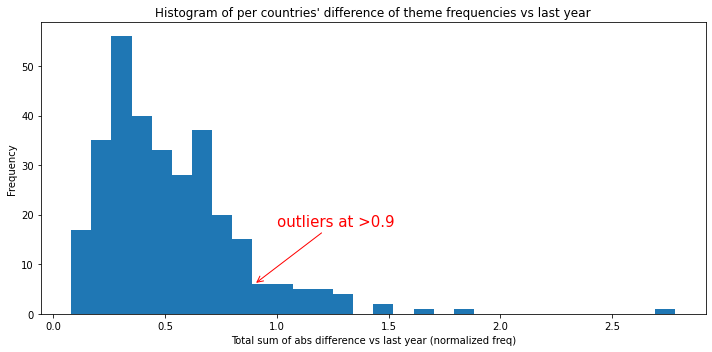

In [124]:
fig, ax = plt.subplots(figsize=(10,5))

(df_gdelt
 .dropna(axis=0, subset=['abs_yoy_diff'])
 .groupby(['event_year', 'Country'])
 .sum()['abs_yoy_diff']
 .reset_index())['abs_yoy_diff'].plot(kind="hist", bins=30, ax=ax)

plt.annotate(xy = (.9, 6), s='outliers at >0.9', color='red',
            xycoords='data', xytext=(1, 20),
            arrowprops=dict(color='red', arrowstyle='->'),
            horizontalalignment='left', verticalalignment='top',
            size=15)

plt.title("Histogram of per countries' difference of theme frequencies vs last year")
plt.xlabel('Total sum of abs difference vs last year (normalized freq)')

fig.tight_layout()
fig.savefig('Figures/5b-Theme Trends - Hist of differences.png', dpi=300);

freq, val = np.histogram(df_gdelt
 .dropna(axis=0, subset=['abs_yoy_diff'])
 .groupby(['event_year', 'Country'])
 .sum()['abs_yoy_diff']
 .reset_index()['abs_yoy_diff'].values, bins=30)

print('Outliers:')
print('Frequency value:',freq[9], '; Abs difference YoY Value:',val[9])

In [130]:
df_theme_change = (df_gdelt
 .dropna(axis=0, subset=['abs_yoy_diff'])
 .groupby(['event_year', 'Country'])
 .sum()['abs_yoy_diff']
 .reset_index())

df_theme_change_raw = df_theme_change.copy()
df_theme_change = df_theme_change[df_theme_change.abs_yoy_diff >= val[9]]
df_theme_change.reset_index(inplace=True, drop=True)

print(f"Original number of theme changes: {len(df_theme_change_raw)} \
vs Filtered number of theme changes: {len(df_theme_change)}")

Original number of theme changes: 312 vs Filtered number of theme changes: 31


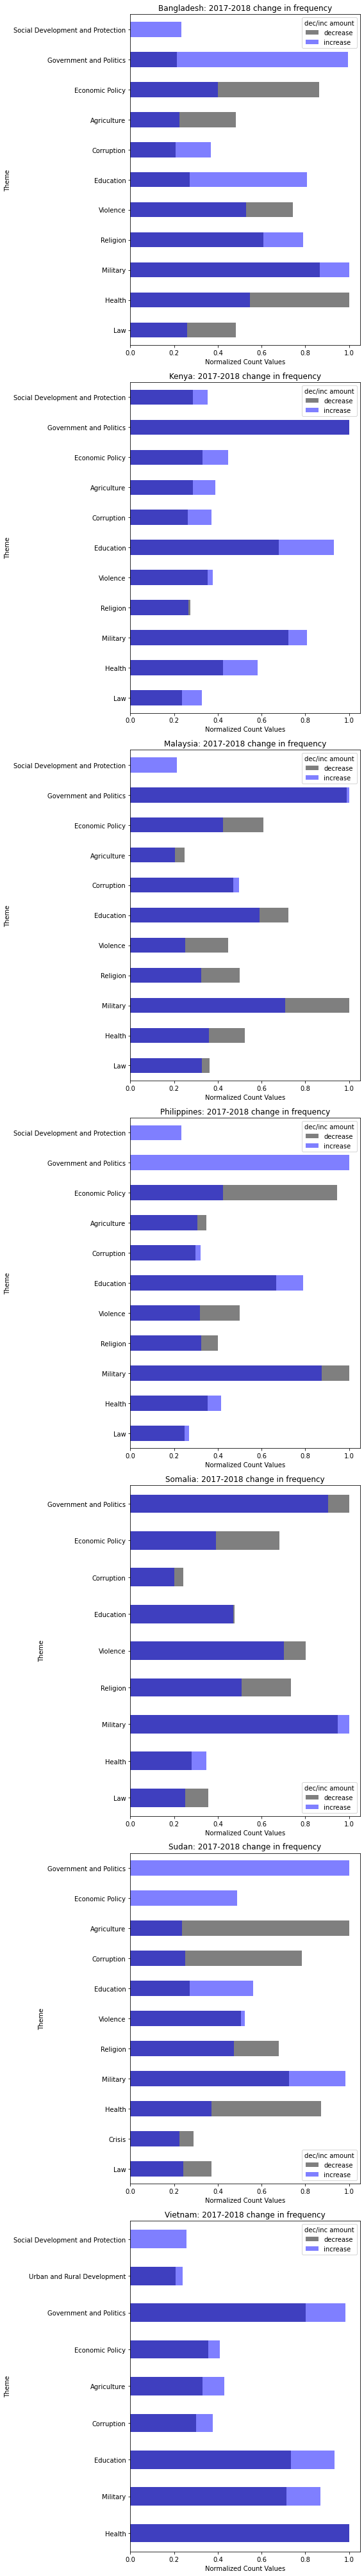

In [131]:
#Plot all countries for 2017-2018

fig, ax = plt.subplots(7, 1, figsize=(8,56));


for i, (idx, each) in enumerate(df_theme_change[df_theme_change.event_year == 2018].iterrows()):

    (df_gdelt[(df_gdelt.Country == each.Country) & (df_gdelt.event_year == each.event_year-1)]
     [['category','count_norm']]).set_index('category').plot(kind='barh', ax=ax[i], label=year-1, width=.5, color='black', alpha=.5)
    (df_gdelt[(df_gdelt.Country == each.Country) & (df_gdelt.event_year == each.event_year)]
     [['category','count_norm']]).set_index('category').plot(kind='barh', ax=ax[i], label=year, width=.5, color='b', alpha=.5)

    ax[i].set_title(f'{each.Country}: {each.event_year-1}-{each.event_year} change in frequency')
    ax[i].legend(['decrease', 'increase'], title="dec/inc amount")
    ax[i].set_xlabel('Normalized Count Values')
    ax[i].set_ylabel('Theme')

fig.tight_layout()
fig.savefig('Figures/5c-Theme Trends - Changes 2018.png', dpi=300);

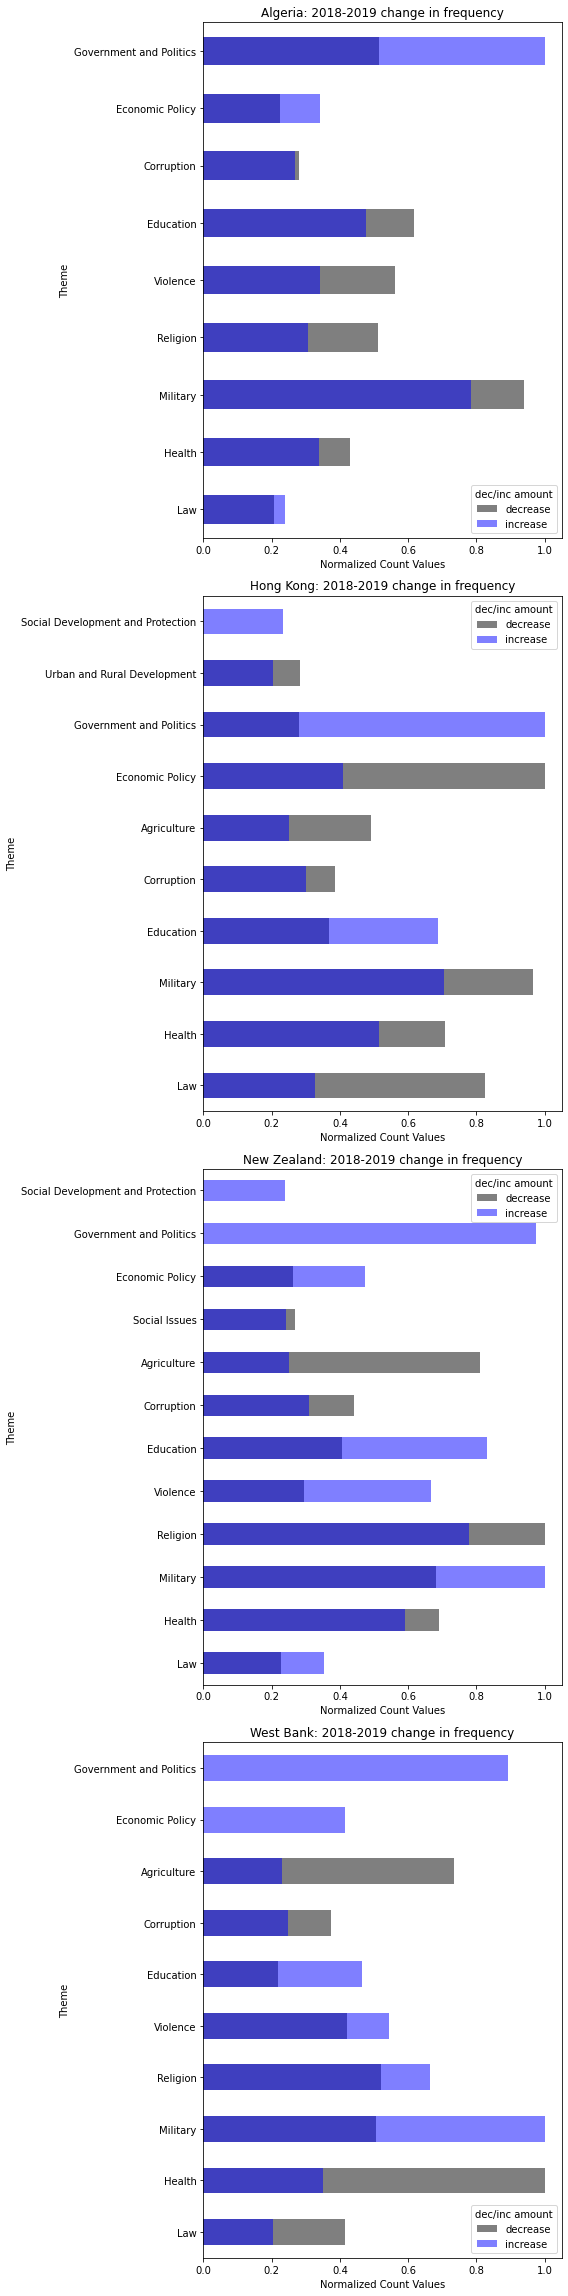

In [132]:
#Plot all countries for 2018-2019

fig, ax = plt.subplots(4, 1, figsize=(8,32));


for i, (idx, each) in enumerate(df_theme_change[df_theme_change.event_year == 2019].iterrows()):

    (df_gdelt[(df_gdelt.Country == each.Country) & (df_gdelt.event_year == each.event_year-1)]
     [['category','count_norm']]).set_index('category').plot(kind='barh', ax=ax[i], label=year-1, width=.5, color='black', alpha=.5)
    (df_gdelt[(df_gdelt.Country == each.Country) & (df_gdelt.event_year == each.event_year)]
     [['category','count_norm']]).set_index('category').plot(kind='barh', ax=ax[i], label=year, width=.5, color='b', alpha=.5)

    ax[i].set_title(f'{each.Country}: {each.event_year-1}-{each.event_year} change in frequency')
    ax[i].legend(['decrease', 'increase'], title="dec/inc amount")
    ax[i].set_xlabel('Normalized Count Values')
    ax[i].set_ylabel('Theme')

fig.tight_layout()
fig.savefig('Figures/5c-Theme Trends - Changes 2019.png', dpi=300);

### Identify Cluster of Countries based on Themes
Use Kmeans clustering to identify cluster of countries based on normalized theme counts as features.

In [139]:
df_for_clusters = df_gdelt_all.pivot_table(index=['event_year', 'Country'], 
                                           columns=['category'], 
                                           values=['count_norm']).reset_index()

mi = df_for_clusters.columns
cols = [y if y else x for (x,y) in mi.tolist()]
df_for_clusters.columns = cols

In [140]:
df_for_clusters.head(2)

,event_year,Country,Agriculture,Corruption,Crime,Crisis,Economic Policy,Education,Government and Politics,Health,Infrastructure,Law,Military,Religion,Social Development and Protection,Social Issues,Urban and Rural Development,Violence
0,2015,Afghanistan,0.081531,0.153630,0.084752,0.078118,0.359675,0.344910,0.660153,0.271066,0.0,0.146967,1.0,0.427020,0.139531,0.071002,0.062410,0.716435
1,2015,Algeria,0.228150,0.230263,0.109001,0.092145,0.476202,0.583516,0.940141,0.305830,0.0,0.223501,1.0,0.634571,0.186541,0.081840,0.100778,0.741347


In [141]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean

def intra_to_inter(X, y, dist, r):
    """Compute intracluster to intercluster distance ratio
    
    Parameters
    ----------
    X : array
        Data matrix with each row corresponding to a point
    y : array
        Class label of each point
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    r : integer
        Number of pairs to sample
        
    Returns
    -------
    ratio : float
        Intracluster to intercluster distance ratio
    """
    dist_P = []
    dist_Q = []
    np.random.seed(11)
    for i, j in np.random.randint(low=0, high=len(y), size=[r,2]):
        # just skip the pair even if we end up having pairs less than r
        if i == j:
            continue
        # intracluster
        elif y[i] == y[j]:
            dist_P.append(dist(X[i], X[j]))
        # intercluster
        else:
            dist_Q.append(dist(X[i], X[j]))
    intra = np.sum(dist_P) / len(dist_P)
    inter = np.sum(dist_Q) / len(dist_Q)
    ratio = intra / inter
    return ratio

In [142]:
X_art = df_for_clusters.drop(axis=1, labels=['event_year', 'Country']).values

# fig, ax = plt.subplots(2, 5, dpi=150, sharex=True, sharey=True, figsize=(7,4),
#                        subplot_kw=dict(aspect='equal'),
#                        gridspec_kw=dict(wspace=0.01))
inertias = []
iidrs = []
scs = []
for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, random_state=1337)
    y = kmeans.fit_predict(X_art)
    inertias.append(kmeans.inertia_)
    iidrs.append(intra_to_inter(X_art, y, euclidean, 50))
    scs.append(silhouette_score(X_art, y))

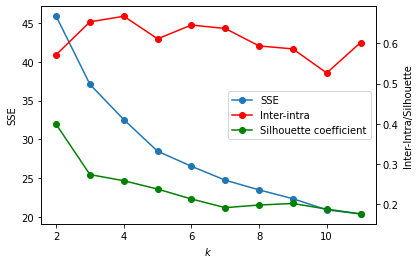

In [143]:
plt.plot(np.arange(2,12), inertias, '-o', label='SSE')
plt.xlabel('$k$')
plt.ylabel('SSE')
lines, labels = plt.gca().get_legend_handles_labels()
plt.twinx()
plt.plot(np.arange(2,12), iidrs, '-ro', label='Inter-intra')
plt.plot(np.arange(2,12), scs, '-go', label='Silhouette coefficient')
plt.ylabel('Inter-Intra/Silhouette')
lines2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(lines+lines2, labels+labels2);
plt.savefig('Figures/6a-KMeans Validators.png', dpi=300);
# k = 7

In [144]:
kmeans = KMeans(n_clusters = 7, random_state = 1337) #why 7?
kmeans.fit(X_art)
cluster_centers = kmeans.cluster_centers_

In [152]:
df_for_clusters['kmeans_y'] = np.nan

for year in years:

    X_art = df_for_clusters[df_for_clusters['event_year'] == year].drop(
        axis=1, labels=['event_year', 'kmeans_y']).set_index('Country').values
    
    y = kmeans.fit_predict(X_art)
    
    df_for_clusters.loc[df_for_clusters[df_for_clusters['event_year'] == year].index, 'kmeans_y'] = y
    
# viewing the assigned clusters for the Philippines YoY
df_for_clusters[df_for_clusters.Country == 'Philippines'][['event_year', 'kmeans_y']]    

,event_year,kmeans_y
50,2015,2.0
128,2016,6.0
206,2017,3.0
284,2018,2.0
362,2019,0.0


In [160]:
df_cluster_centers = pd.DataFrame(cluster_centers, columns = df_for_clusters.columns[2:-1])

df_cluster_centers_imptfeatures = df_cluster_centers.copy()

for col in df_cluster_centers.columns:
    df_cluster_centers_imptfeatures[col] = df_cluster_centers[col] - df_cluster_centers[col].mean()
    
df_cluster_centers_imptfeatures.head(1) #distance of 1 cluster's themes from the average of all cluster values for each theme

,Agriculture,Corruption,Crime,Crisis,Economic Policy,Education,Government and Politics,Health,Infrastructure,Law,Military,Religion,Social Development and Protection,Social Issues,Urban and Rural Development,Violence
0,-0.081491,-0.030886,-0.009148,0.006287,0.093946,-0.225146,0.031369,-0.154675,-0.001489,-0.010319,-0.006364,-0.123802,-0.04549,-0.013412,-0.059649,-0.047979


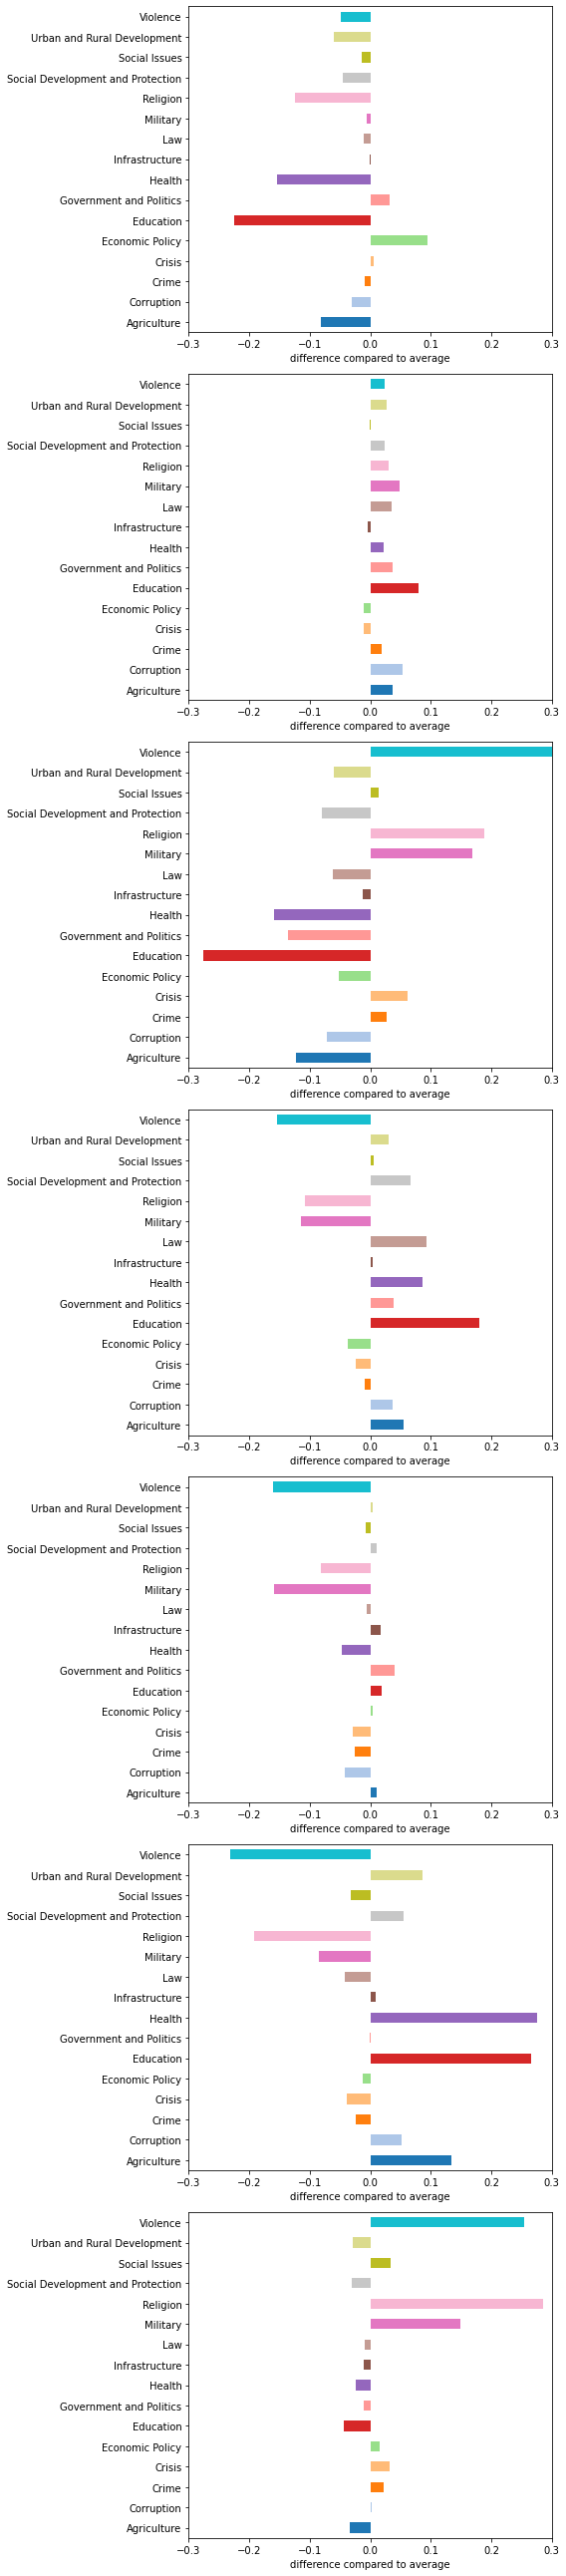

In [170]:
import matplotlib

cmap = matplotlib.cm.get_cmap('tab20')
colors = [cmap(x) for x in np.arange(0, 1, 1/len(df_cluster_centers_imptfeatures.columns))]

fig, ax = plt.subplots(7, 1, figsize=(8,36));
for idx, each in df_cluster_centers_imptfeatures.iterrows():
    each.plot(kind='barh', ax=ax[idx], color=colors)
    ax[idx].set_xlim(-.3, .3)
    ax[idx].set_xlabel('difference compared to average')
    
fig.tight_layout()    
fig.savefig('Figures/6b-Cluster Centers.png', dpi=300);

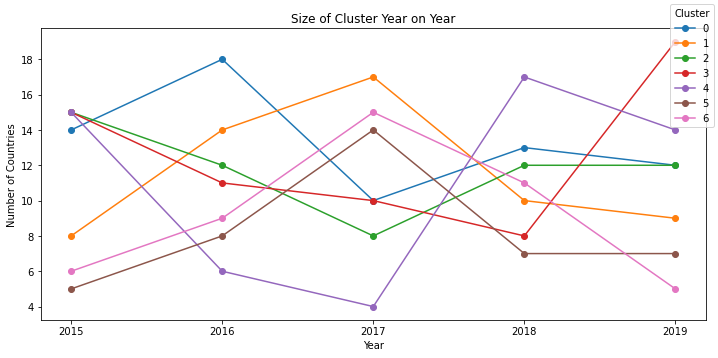

In [171]:
# Plotting the YoY change of cluster sizes

df_clusters = pd.DataFrame(index = range(7), columns=years)
for year in years:
    df_clusters[year] = df_for_clusters[df_for_clusters['event_year'] == year]\
            .groupby('kmeans_y').count()['Country'].values

fig, ax = plt.subplots(figsize=(10,5))
df_clusters.T.plot(kind='line', style='o-', ax=ax, legend=False)
plt.xticks(years)
fig.legend(title='Cluster')

plt.title('Size of Cluster Year on Year');
plt.ylabel('Number of Countries')
plt.xlabel('Year')

fig.tight_layout()
fig.savefig('Figures/6c-Cluster Sizes.png', dpi=300);

In [172]:
df_theme_changes = pd.Series(index=countries)

for country in countries:
    temp_themes = df_for_clusters[df_for_clusters['Country'] == country]\
            .sort_values('event_year')['kmeans_y'].values
    temp_count = 0

    for i, x in enumerate(temp_themes):
        if i == 0:
            pass
        else:
            if x != temp_themes[i-1]:
                temp_count += 1
    df_theme_changes[country] = temp_count
df_theme_changes = df_theme_changes.astype(int)

<ipython-input-172-941f6e638a0c>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_theme_changes = pd.Series(index=countries)


4    58
3    20
dtype: int64

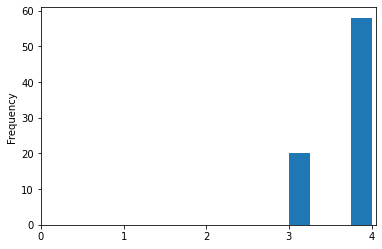

In [178]:
display(df_theme_changes.value_counts())
df_theme_changes.plot(kind='hist', bins=4)
plt.xticks(list(range(5)));

In [179]:
df_theme_movements = pd.DataFrame(data=0, index=range(7), columns=range(7))

for country in countries:
    temp_themes = df_for_clusters[df_for_clusters['Country'] == country]\
            .sort_values('event_year')['kmeans_y'].values
    
    for i, x in enumerate(temp_themes):
        if i == len(temp_themes)-1:
            pass
        else:
            df_theme_movements.loc[int(x), int(temp_themes[i+1])] += 1

In [180]:
df_theme_movements

,0,1,2,3,4,5,6
0,7,13,9,11,0,10,5
1,5,11,7,9,13,4,0
2,10,5,0,4,0,4,24
3,1,17,9,0,1,14,2
4,11,1,5,21,0,0,4
5,9,3,12,0,7,0,3
6,10,0,2,3,20,4,2


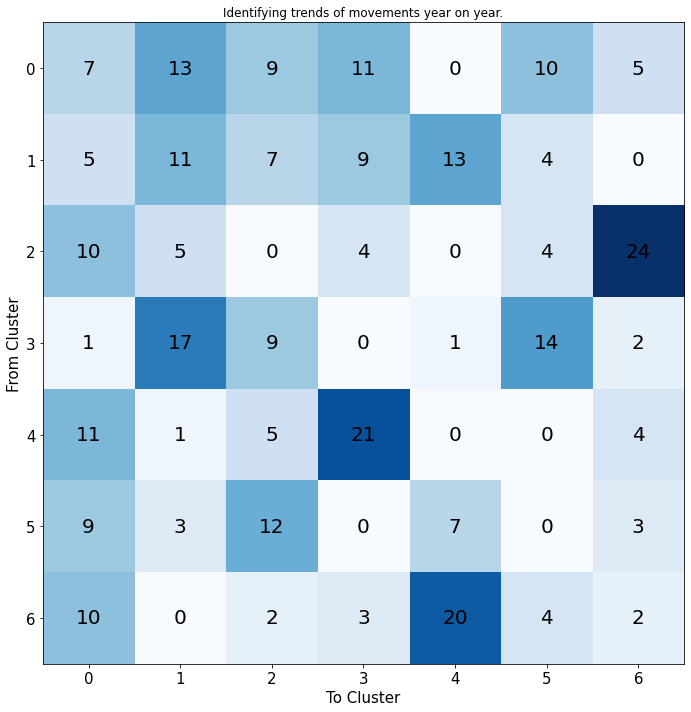

In [194]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(df_theme_movements, cmap='Blues')

for idx, each in df_theme_movements.iterrows():
    for i,e in enumerate(each):
        ax.annotate(xy=(i, idx), text=e, horizontalalignment='center', 
                    verticalalignment='center', size=20)
        
ax.set_ylabel('From Cluster', fontsize=15)
ax.set_xlabel('To Cluster', fontsize=15)

ax.tick_params(labelsize=15)
plt.title('Identifying trends of movements year on year.')

fig.tight_layout()
fig.savefig('Figures/6d-Cluster Movements.png', dpi=300);

In [184]:
df_clusters

,2015,2016,2017,2018,2019
0,14,18,10,13,12
1,8,14,17,10,9
2,15,12,8,12,12
3,15,11,10,8,19
4,15,6,4,17,14
5,5,8,14,7,7
6,6,9,15,11,5


In [193]:
#Identifying the largest cluster YoY
df_uso = df_clusters.idxmax()

df_uso[2015] = '2,3,4'

df_uso

2015    2,3,4
2016        0
2017        1
2018        4
2019        3
dtype: object

In [195]:
df_country_clusters_ordered = pd.Series(index = countries)

for country in countries:
    df_country_clusters_ordered[country] = 'c'+''.join(
        df_for_clusters[df_for_clusters.Country == country] \
        .sort_values('event_year') \
        .kmeans_y.values.astype(int).astype(str)
    )
    
df_country_clusters_ordered.head()
#the order of values show which cluster they belong to YoY.

<ipython-input-195-70ffcfed4d12>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_country_clusters_ordered = pd.Series(index = countries)


Afghanistan    c11264
Algeria        c35011
Argentina      c00543
Armenia        c31351
Australia      c43132
dtype: object

In [192]:
# NOTE: I don't remember what this block of code is for. 

# uso_list = ['c00143', 'c20143', 'c30143', 'c40143']
# uso_list_1 = ['c01430', 'c01431', 'c01432', 'c01433', 'c01434', 'c01435', 'c01436']

# display(df_country_clusters_ordered[df_country_clusters_ordered.isin(uso_list)])

# display(df_country_clusters_ordered[df_country_clusters_ordered.isin(uso_list_1)])

c11264    6
c43132    5
c02603    4
c52603    3
c00543    3
dtype: int64

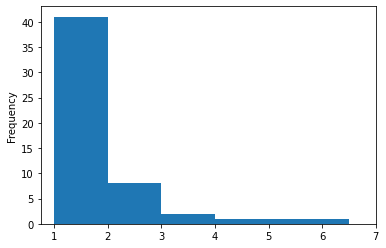

In [199]:
# Top cluster movements from years 2015-2019
display(df_country_clusters_ordered.value_counts().head())
df_country_clusters_ordered.value_counts().plot(kind='hist', width=1);
plt.xticks(range(1,8));

Countries that have similar movements from cluster to cluster in the identified time period.

In [191]:
df_country_clusters_ordered[df_country_clusters_ordered=='c11264']

Afghanistan    c11264
Iraq           c11264
Lebanon        c11264
Syria          c11264
West Bank      c11264
Yemen          c11264
dtype: object

In [69]:
df_country_clusters_ordered[df_country_clusters_ordered=='c43132']

Australia    c43132
China        c43132
Japan        c43132
Taiwan       c43132
Vietnam      c43132
dtype: object

In [70]:
df_country_clusters_ordered[df_country_clusters_ordered=='c02603']

Czech Republic    c02603
Germany           c02603
Greece            c02603
Poland            c02603
dtype: object

## Network Representation

### Unipartite

In [72]:
c = []
for each in G[2018].nodes:
    if each in countries:
        c.append('red')
    else:
        c.append('green')

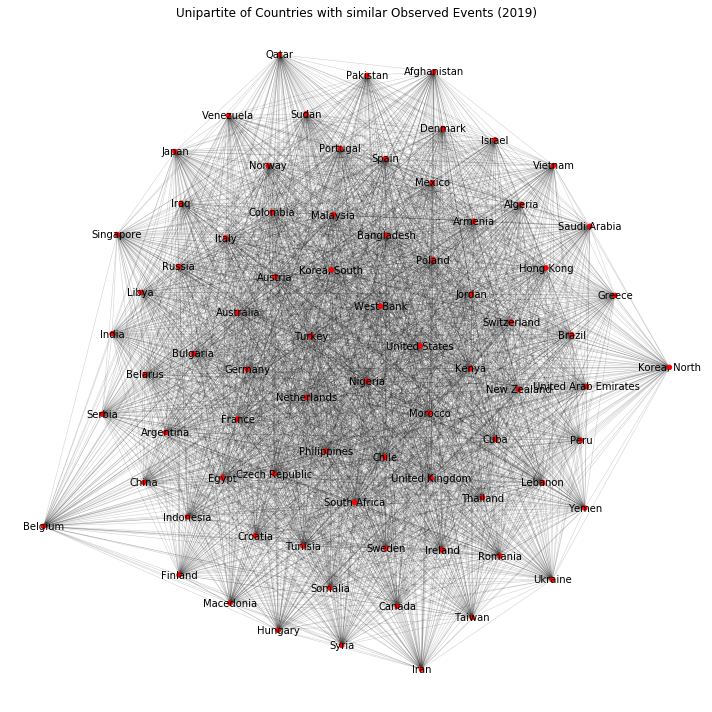

In [99]:
temp_G = G_proj[2019]
fig, ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(temp_G, k=3)

# nodes
nx.draw_networkx_nodes(temp_G, pos, node_color=list(c), node_size=20)

# edges
nx.draw_networkx_edges(temp_G, pos, width=.5, alpha=.2)

# labels
nx.draw_networkx_labels(temp_G, pos, font_color="black", font_size = 10)

ax.axis('off');
# fig.savefig('simple_plot.png', dpi=300);
ax.set_title('Unipartite of Countries with similar Observed Events (2019)')

fig.tight_layout()
fig.savefig('Figures/7a-Projected Unipartite 2019.png', dpi=300);

### Bipartite

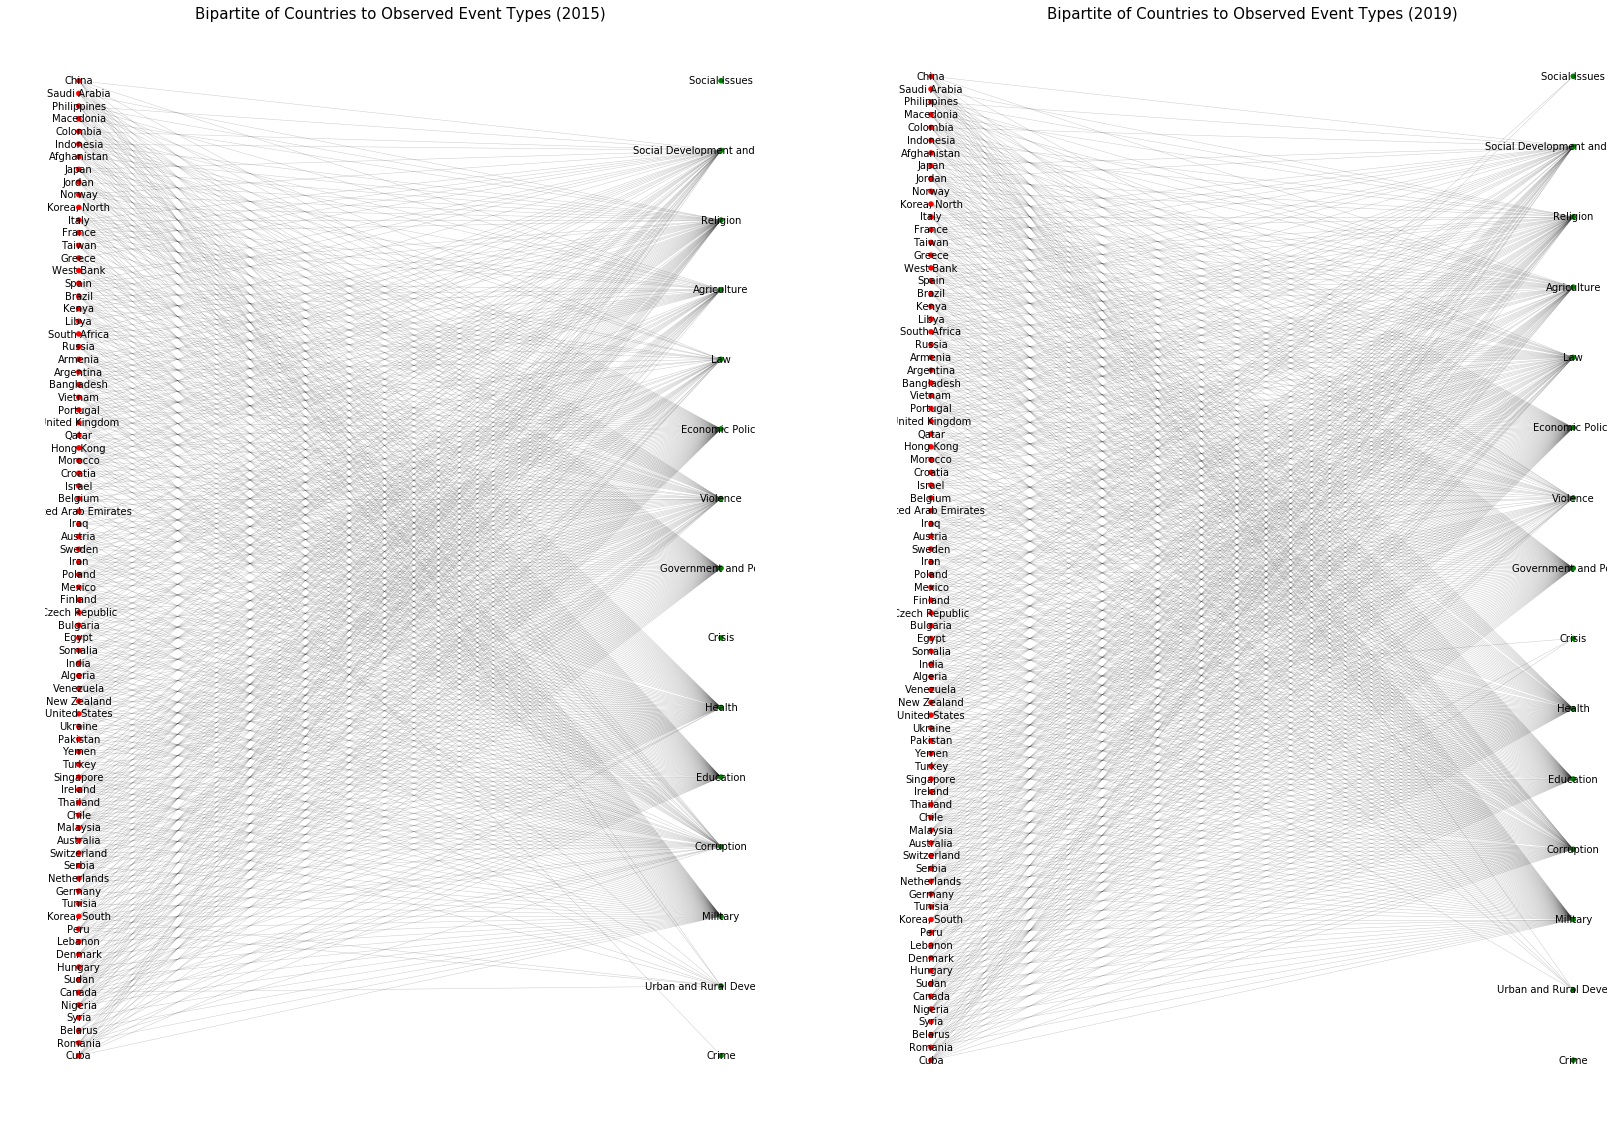

In [84]:
temp_G = G[2015]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28,20))
pos = nx.bipartite_layout(temp_G, countries, aspect_ratio=4)

# nodes
nx.draw_networkx_nodes(temp_G, pos, node_color=list(c), node_size=20, ax=ax1)

# edges
nx.draw_networkx_edges(temp_G, pos, width=.5, alpha=.2, ax=ax1)

# labels
nx.draw_networkx_labels(temp_G, pos, font_color="black", font_size = 10, ax=ax1)
ax1.set_title('Bipartite of Countries to Observed Event Types (2015)', size=15)
ax1.axis('off');

temp_G = G[2019]
pos = nx.bipartite_layout(temp_G, countries)

# nodes
nx.draw_networkx_nodes(temp_G, pos, node_color=list(c), node_size=20, ax=ax2)

# edges
nx.draw_networkx_edges(temp_G, pos, width=.5, alpha=.2, ax=ax2)

# labels
nx.draw_networkx_labels(temp_G, pos, font_color="black", font_size = 10, ax=ax2)
ax2.set_title('Bipartite of Countries to Observed Event Types (2019)', size=15)
ax2.axis('off');
fig.savefig('1-network comparison.png', dpi=300);

# fig.tight_layout()
fig.savefig('Figures/7b-Bipartite 2015 and 2019.png', dpi=300);

In [85]:
len(G[2015].edges)

703

In [86]:
len(G[2019].edges)

733